In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d emmarex/plantdisease

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 97% 640M/658M [00:06<00:00, 146MB/s]
100% 658M/658M [00:07<00:00, 98.1MB/s]


In [ ]:
!unzip plantdisease.zip

Streaming output truncated to the last 5000 lines.
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0922e026-b563-438d-b9ed-74

In [ ]:
!ls

kaggle.json  plantdisease.zip  plantvillage  PlantVillage  sample_data


In [ ]:
DATASET_PATH = "/content/PlantVillage"

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
os.listdir(DATASET_PATH)

['Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Pepper__bell___healthy',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Potato___Late_blight',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_Septoria_leaf_spot',
 'Potato___healthy',
 'Tomato_Leaf_Mold',
 'Potato___Early_blight',
 'Tomato_Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Tomato_Late_blight',
 'Tomato_healthy',
 'Tomato__Target_Spot',
 'Tomato_Early_blight']

In [ ]:
classes = os.listdir(DATASET_PATH)
print("Number of classes:", len(classes))

Number of classes: 15


In [ ]:
class_counts = {}

for c in classes:
    class_counts[c] = len(os.listdir(os.path.join(DATASET_PATH, c)))

class_counts

{'Potato___healthy': 152,
 'Pepper__bell___Bacterial_spot': 997,
 'Tomato_healthy': 1591,
 'Tomato__Tomato_mosaic_virus': 373,
 'Tomato_Septoria_leaf_spot': 1771,
 'Tomato_Early_blight': 1000,
 'Tomato_Leaf_Mold': 952,
 'Tomato_Late_blight': 1909,
 'Tomato_Bacterial_spot': 2127,
 'Tomato_Spider_mites_Two_spotted_spider_mite': 1676,
 'Tomato__Target_Spot': 1404,
 'Tomato__Tomato_YellowLeaf__Curl_Virus': 3209,
 'Potato___Early_blight': 1000,
 'Pepper__bell___healthy': 1478,
 'Potato___Late_blight': 1000}

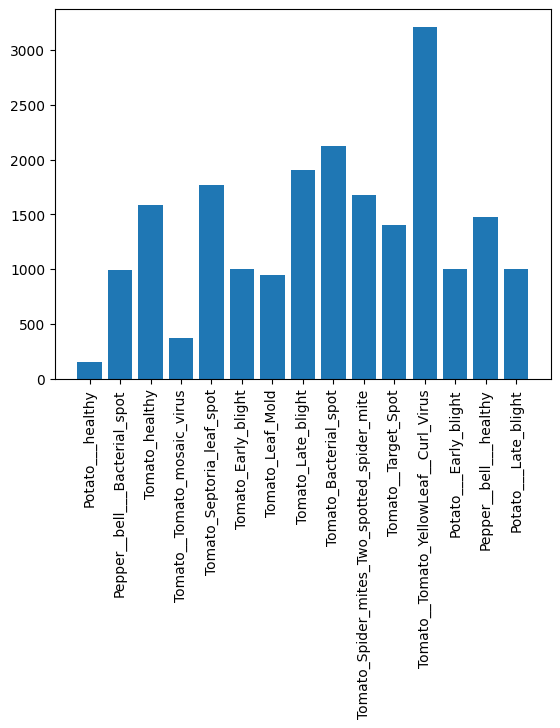

In [ ]:
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.show()

In [ ]:
img_size = 128
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
train_data = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 16516 images belonging to 15 classes.


In [ ]:
val_data = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 4122 images belonging to 15 classes.


In [ ]:
labels = train_data.classes

weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(weights))
print(class_weights)

{0: np.float64(1.379782790309106), 1: np.float64(0.9307410538179769), 2: np.float64(1.3763333333333334), 3: np.float64(1.3763333333333334), 4: np.float64(9.025136612021859), 5: np.float64(0.6469251860556209), 6: np.float64(1.3763333333333334), 7: np.float64(0.7205933682373473), 8: np.float64(1.4449693788276465), 9: np.float64(0.7770406963067513), 10: np.float64(0.8210787969177231), 11: np.float64(0.9795966785290628), 12: np.float64(0.4289313076223867), 13: np.float64(3.6824972129319957), 14: np.float64(0.8649384655669023)}


In [ ]:
num_classes = train_data.num_classes

model = models.Sequential()

# BLOCK 1
model.add(layers.Conv2D(32, (3,3), activation='relu',
                        input_shape=(128,128,3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())

# BLOCK 2
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())

# BLOCK 3
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())

# BLOCK 4
model.add(layers.Conv2D(256, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())

# FLATTEN
model.add(layers.Flatten())

# DENSE
model.add(layers.Dense(256, activation='relu',
        kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.Dropout(0.5))

# OUTPUT
model.add(layers.Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,753,743 (10.50 MB)

 Trainable params: 2,752,783 (10.50 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    class_weight=class_weights
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 124s 215ms/step - accuracy: 0.3455 - loss: 3.3823 - val_accuracy: 0.2409 - val_loss: 5.2796
Epoch 2/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 99s 192ms/step - accuracy: 0.5263 - loss: 2.0999 - val_accuracy: 0.5078 - val_loss: 2.4431
Epoch 3/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 100s 193ms/step - accuracy: 0.5741 - loss: 1.8239 - val_accuracy: 0.2411 - val_loss: 7.1867
Epoch 4/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 99s 191ms/step - accuracy: 0.6364 - loss: 1.5290 - val_accuracy: 0.4178 - val_loss: 4.4235
Epoch 5/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 99s 192ms/step - accuracy: 0.7046 - loss: 1.3007 - val_accuracy: 0.7700 - val_loss: 1.1062
Epoch 6/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 98s 189ms/step - accuracy: 0.7550 - loss: 1.1103 - val_accuracy: 0.6346 - val_loss: 1.5000
Epoch 7/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 97s 187ms/step - accuracy: 0.7692 - loss: 1.0790 - val_accuracy: 0.6482 - val_loss: 1.6045
Epoch 8/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 97s 189ms/step - accuracy: 0.7874 - loss:

In [ ]:
model1 = model
history1 = history

In [ ]:
model2 = models.Sequential()

# BLOCK 1
model2.add(layers.Conv2D(32,(3,3),padding='same',activation='relu',
                         input_shape=(128,128,3)))
model2.add(layers.BatchNormalization())
model2.add(layers.Conv2D(32,(3,3),padding='same',activation='relu'))
model2.add(layers.MaxPooling2D())

# BLOCK 2
model2.add(layers.Conv2D(64,(3,3),padding='same',activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Conv2D(64,(3,3),padding='same',activation='relu'))
model2.add(layers.MaxPooling2D())

# BLOCK 3
model2.add(layers.Conv2D(128,(3,3),padding='same',activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Conv2D(128,(3,3),padding='same',activation='relu'))
model2.add(layers.MaxPooling2D())

# BLOCK 4
model2.add(layers.Conv2D(256,(3,3),padding='same',activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D())

# CLASSIFIER
model2.add(layers.Flatten())
model2.add(layers.Dense(512,activation='relu',
         kernel_regularizer=regularizers.l2(0.0005)))
model2.add(layers.Dropout(0.4))
model2.add(layers.Dense(num_classes,activation='softmax'))

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,980,911 (34.26 MB)

 Trainable params: 8,979,951 (34.26 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3
)

history2 = model2.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    class_weight=class_weights,
    callbacks=[callback]
)

Epoch 1/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 117s 227ms/step - accuracy: 0.3118 - loss: 4.1659 - val_accuracy: 0.1354 - val_loss: 4.8711 - learning_rate: 0.0010
Epoch 2/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 106s 205ms/step - accuracy: 0.5041 - loss: 2.0574 - val_accuracy: 0.5136 - val_loss: 2.1615 - learning_rate: 0.0010
Epoch 3/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 104s 201ms/step - accuracy: 0.5932 - loss: 1.6519 - val_accuracy: 0.3777 - val_loss: 2.6237 - learning_rate: 0.0010
Epoch 4/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 105s 203ms/step - accuracy: 0.6279 - loss: 1.4962 - val_accuracy: 0.2965 - val_loss: 3.1232 - learning_rate: 0.0010
Epoch 5/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 103s 200ms/step - accuracy: 0.6996 - loss: 1.2232 - val_accuracy: 0.7074 - val_loss: 1.1472 - learning_rate: 0.0010
Epoch 6/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 103s 198ms/step - accuracy: 0.7403 - loss: 1.0910 - val_accuracy: 0.4762 - val_loss: 3.7556 - learning_rate: 0.0010
Epoch 7/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 103s 199ms/step - accura

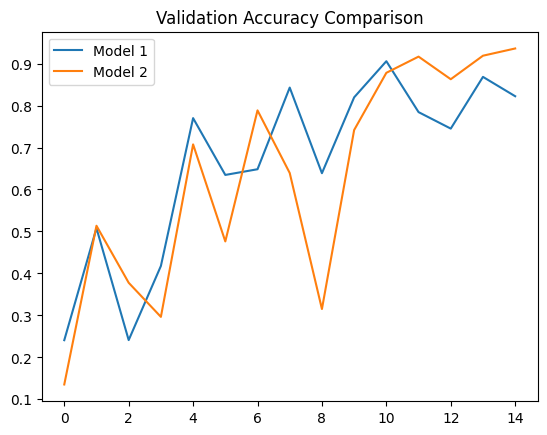

In [ ]:
plt.plot(history1.history['val_accuracy'],label='Model 1')
plt.plot(history2.history['val_accuracy'],label='Model 2')
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.show()

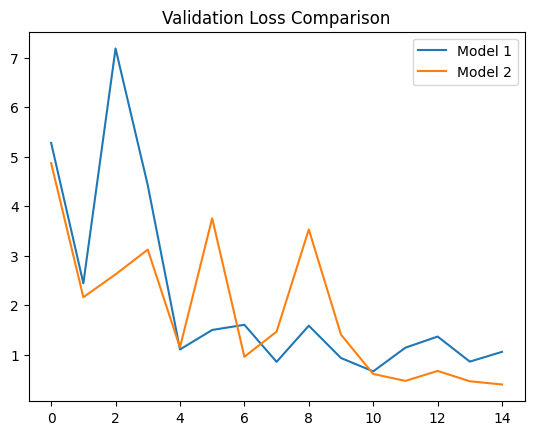

In [ ]:
plt.plot(history1.history['val_loss'],label='Model 1')
plt.plot(history2.history['val_loss'],label='Model 2')
plt.title("Validation Loss Comparison")
plt.legend()
plt.show()

In [ ]:
loss1, acc1 = model1.evaluate(val_data)
loss2, acc2 = model2.evaluate(val_data)

print("Model 1 Accuracy:",acc1)
print("Model 2 Accuracy:",acc2)

129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - accuracy: 0.8380 - loss: 1.0377
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - accuracy: 0.9379 - loss: 0.4049
Model 1 Accuracy: 0.8316351175308228
Model 2 Accuracy: 0.9357108473777771


In [ ]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,940,815 (102.77 MB)

 Trainable params: 8,979,951 (34.26 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 17,959,904 (68.51 MB)

MODEL 1

Conv → BN → Pool

Conv → BN → Pool

Conv → BN → Pool

Conv → BN → Pool

Dense → Dropout → Softmax


MODEL 2

Conv → BN → Conv → Pool

Conv → BN → Conv → Pool

Conv → BN → Conv → Pool

Conv → BN → Pool

Dense(512) → Dropout → Softmax


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import numpy as np

def evaluate_model(model, val_data):
    val_data.reset()
    preds = model.predict(val_data)
    y_pred = np.argmax(preds, axis=1)
    y_true = val_data.classes

    acc = np.mean(y_pred == y_true)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    micro_f1 = f1_score(y_true, y_pred, average='micro')

    print("Accuracy:", acc)
    print("Macro F1:", macro_f1)
    print("Micro F1:", micro_f1)

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred))

    return acc, macro_f1, micro_f1

In [ ]:
model_baseline = tf.keras.models.clone_model(model2)
model_baseline.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_baseline = model_baseline.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)

Epoch 1/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 136s 246ms/step - accuracy: 0.4231 - loss: 3.5073 - val_accuracy: 0.2479 - val_loss: 4.7903
Epoch 2/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 106s 205ms/step - accuracy: 0.6459 - loss: 1.5825 - val_accuracy: 0.6429 - val_loss: 1.5244
Epoch 3/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 122s 235ms/step - accuracy: 0.7448 - loss: 1.1468 - val_accuracy: 0.7091 - val_loss: 1.3055
Epoch 4/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 107s 206ms/step - accuracy: 0.7768 - loss: 0.9985 - val_accuracy: 0.5611 - val_loss: 2.3374
Epoch 5/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 105s 203ms/step - accuracy: 0.8240 - loss: 0.8729 - val_accuracy: 0.3971 - val_loss: 3.0747


In [ ]:
labels = train_data.classes

from sklearn.utils import class_weight
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(weights))
print(class_weights)

{0: np.float64(1.379782790309106), 1: np.float64(0.9307410538179769), 2: np.float64(1.3763333333333334), 3: np.float64(1.3763333333333334), 4: np.float64(9.025136612021859), 5: np.float64(0.6469251860556209), 6: np.float64(1.3763333333333334), 7: np.float64(0.7205933682373473), 8: np.float64(1.4449693788276465), 9: np.float64(0.7770406963067513), 10: np.float64(0.8210787969177231), 11: np.float64(0.9795966785290628), 12: np.float64(0.4289313076223867), 13: np.float64(3.6824972129319957), 14: np.float64(0.8649384655669023)}


In [ ]:
model_weighted = tf.keras.models.clone_model(model2)
model_weighted.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_weighted = model_weighted.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    class_weight=class_weights
)

Epoch 1/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 119s 214ms/step - accuracy: 0.3266 - loss: 3.6780 - val_accuracy: 0.3692 - val_loss: 2.7391
Epoch 2/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 105s 203ms/step - accuracy: 0.5249 - loss: 2.0017 - val_accuracy: 0.2783 - val_loss: 5.2639
Epoch 3/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 107s 207ms/step - accuracy: 0.6075 - loss: 1.6352 - val_accuracy: 0.4544 - val_loss: 4.7927
Epoch 4/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 108s 209ms/step - accuracy: 0.6679 - loss: 1.3744 - val_accuracy: 0.5616 - val_loss: 2.4765
Epoch 5/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 106s 204ms/step - accuracy: 0.7199 - loss: 1.2361 - val_accuracy: 0.7334 - val_loss: 1.2871


In [ ]:
minority_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.15,
    height_shift_range=0.15,
    brightness_range=[0.7,1.3],
    horizontal_flip=True
)

In [ ]:
train_aug = minority_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_aug = minority_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


In [ ]:
model_aug = tf.keras.models.clone_model(model2)
model_aug.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_aug = model_aug.fit(
    train_aug,
    validation_data=val_aug,
    epochs=5
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 138s 251ms/step - accuracy: 0.3514 - loss: 3.6006 - val_accuracy: 0.3991 - val_loss: 2.8160
Epoch 2/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 123s 238ms/step - accuracy: 0.5561 - loss: 1.8259 - val_accuracy: 0.4262 - val_loss: 2.8846
Epoch 3/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 124s 240ms/step - accuracy: 0.6470 - loss: 1.4615 - val_accuracy: 0.2305 - val_loss: 14.3442
Epoch 4/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 121s 234ms/step - accuracy: 0.7015 - loss: 1.2273 - val_accuracy: 0.7205 - val_loss: 1.1579
Epoch 5/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 122s 235ms/step - accuracy: 0.7367 - loss: 1.1250 - val_accuracy: 0.4187 - val_loss: 2.6716


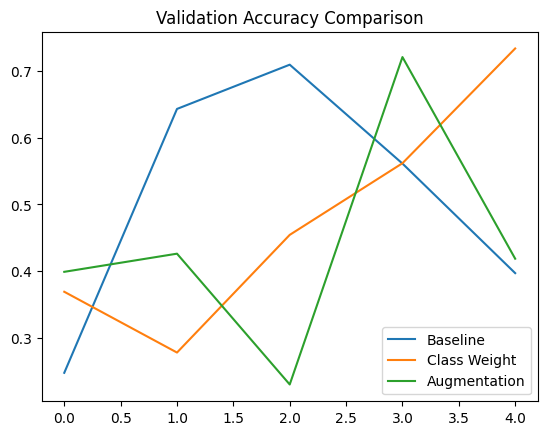

In [ ]:
plt.plot(history_baseline.history['val_accuracy'], label="Baseline")
plt.plot(history_weighted.history['val_accuracy'], label="Class Weight")
plt.plot(history_aug.history['val_accuracy'], label="Augmentation")
plt.legend()
plt.title("Validation Accuracy Comparison")
plt.show()

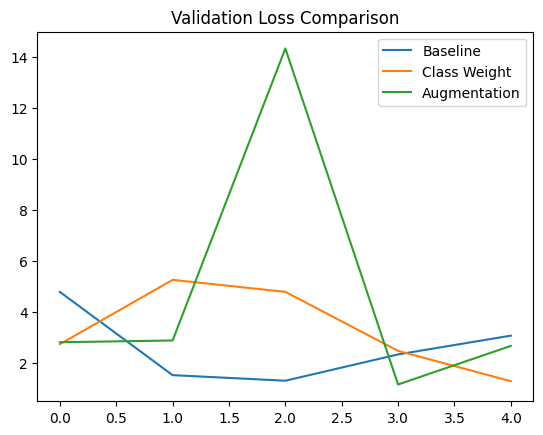

In [ ]:
plt.plot(history_baseline.history['val_loss'], label="Baseline")
plt.plot(history_weighted.history['val_loss'], label="Class Weight")
plt.plot(history_aug.history['val_loss'], label="Augmentation")
plt.legend()
plt.title("Validation Loss Comparison")
plt.show()

In [ ]:
import tensorflow.keras.backend as K

def focal_loss(gamma=2., alpha=0.25):

    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-9, 1-1e-9)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        return K.mean(weight * cross_entropy)

    return loss


In [ ]:
model_focal = tf.keras.models.clone_model(model2)

model_focal.compile(
    optimizer='adam',
    loss=focal_loss(),
    metrics=['accuracy']
)

In [ ]:
history_focal = model_focal.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)

Epoch 1/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 111s 214ms/step - accuracy: 0.5045 - loss: 0.0654 - val_accuracy: 0.5323 - val_loss: 0.0392
Epoch 2/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 104s 201ms/step - accuracy: 0.6435 - loss: 0.0275 - val_accuracy: 0.4229 - val_loss: 0.0505
Epoch 3/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 104s 202ms/step - accuracy: 0.7145 - loss: 0.0198 - val_accuracy: 0.7635 - val_loss: 0.0174
Epoch 4/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 110s 213ms/step - accuracy: 0.7593 - loss: 0.0169 - val_accuracy: 0.5495 - val_loss: 0.0311
Epoch 5/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 104s 202ms/step - accuracy: 0.7732 - loss: 0.0169 - val_accuracy: 0.3481 - val_loss: 0.0449


In [ ]:
acc_focal, macro_focal, micro_focal = evaluate_model(model_focal, val_data)

129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step
Accuracy: 0.0732654051431344
Macro F1: 0.048595433250104174
Micro F1: 0.0732654051431344

Classification Report:

              precision    recall  f1-score   support

           0       0.09      0.02      0.03       199
           1       0.08      0.04      0.05       295
           2       0.06      0.09      0.07       200
           3       0.03      0.01      0.01       200
           4       0.00      0.00      0.00        30
           5       0.09      0.03      0.05       425
           6       0.06      0.07      0.06       200
           7       0.09      0.20      0.13       381
           8       0.05      0.44      0.09       190
           9       0.07      0.02      0.03       354
          10       0.08      0.02      0.03       335
          11       0.00      0.00      0.00       280
          12       0.17      0.04      0.06       641
          13       0.00      0.00      0.00        74
          14       0.08      0.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
val_data.reset()
preds = model_weighted.predict(val_data)

adjusted_preds = []

for p in preds:
    if p.max() < 0.6:
        adjusted_preds.append(np.argsort(p)[-2])
    else:
        adjusted_preds.append(np.argmax(p))

y_true = val_data.classes

129/129 ━━━━━━━━━━━━━━━━━━━━ 23s 173ms/step


In [ ]:
from sklearn.metrics import f1_score

acc_thresh = np.mean(np.array(adjusted_preds)==y_true)
macro_thresh = f1_score(y_true, adjusted_preds, average='macro')
micro_thresh = f1_score(y_true, adjusted_preds, average='micro')

print("Threshold Accuracy:",acc_thresh)
print("Threshold Macro F1:",macro_thresh)
print("Threshold Micro F1:",micro_thresh)

Threshold Accuracy: 0.07472100921882581
Threshold Macro F1: 0.06411524447465472
Threshold Micro F1: 0.07472100921882581


PROBLEM STATEMENT 3

In [ ]:
from tensorflow.keras.applications import MobileNet, VGG16
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, balanced_accuracy_score
import time
import pandas as pd
import numpy as np

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score

def evaluate_all(model, val_data, name):

    val_data.reset()

    start = time.time()
    probs = model.predict(val_data)
    infer_time = time.time() - start

    y_pred = np.argmax(probs, axis=1)
    y_true = val_data.classes

    acc = np.mean(y_pred == y_true)
    macro_f1 = f1_score(y_true,y_pred,average='macro')
    bal_acc = balanced_accuracy_score(y_true,y_pred)

    recalls = f1_score(y_true,y_pred,average=None)
    gmean = np.sqrt(np.prod(recalls))

    roc = roc_auc_score(tf.keras.utils.to_categorical(y_true),probs,multi_class='ovr')
    pr = average_precision_score(tf.keras.utils.to_categorical(y_true),probs)

    print("\n==========",name,"==========")
    print("Accuracy:",acc)
    print("Macro F1:",macro_f1)
    print("Balanced Accuracy:",bal_acc)
    print("G-Mean:",gmean)
    print("ROC-AUC:",roc)
    print("PR-AUC:",pr)
    print("Inference Time:",infer_time)

    print("\nClassification Report\n")
    print(classification_report(y_true,y_pred))

    return acc, macro_f1, bal_acc, gmean, roc, pr, infer_time

In [ ]:
mobilenet_base = MobileNet(
    input_shape=(128,128,3),
    weights="imagenet",
    include_top=False
)

mobilenet_base.trainable = False

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model_mobile = tf.keras.Sequential([
    mobilenet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(train_data.num_classes,activation='softmax')
])

In [ ]:
model_mobile.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)

In [ ]:
hist_mobile = model_mobile.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    class_weight=class_weights
)

Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 160s 267ms/step - accuracy: 0.6055 - loss: 1.2827 - top_k_categorical_accuracy: 0.8952 - val_accuracy: 0.8743 - val_loss: 0.3789 - val_top_k_categorical_accuracy: 0.9939
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 96s 186ms/step - accuracy: 0.8346 - loss: 0.4979 - top_k_categorical_accuracy: 0.9913 - val_accuracy: 0.8913 - val_loss: 0.3052 - val_top_k_categorical_accuracy: 0.9956
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 96s 185ms/step - accuracy: 0.8618 - loss: 0.3903 - top_k_categorical_accuracy: 0.9947 - val_accuracy: 0.9059 - val_loss: 0.2722 - val_top_k_categorical_accuracy: 0.9971
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 95s 184ms/step - accuracy: 0.8813 - loss: 0.3330 - top_k_categorical_accuracy: 0.9958 - val_accuracy: 0.9025 - val_loss: 0.2910 - val_top_k_categorical_accuracy: 0.9971
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 95s 183ms/step - accuracy: 0.8943 - loss: 0.2994 - top_k_categorical_accuracy: 0.9975 - val_accuracy: 0.9129 - val_loss: 0.

In [ ]:
mobile_results = evaluate_all(model_mobile,val_data,"MobileNet")

129/129 ━━━━━━━━━━━━━━━━━━━━ 32s 181ms/step

========== MobileNet ==========
Accuracy: 0.08272683163512858
Macro F1: 0.0666017831184947
Balanced Accuracy: 0.06669177510333693
G-Mean: 0.0
ROC-AUC: 0.49658351655910415
PR-AUC: 0.06735796009264641
Inference Time: 32.701581716537476

Classification Report

              precision    recall  f1-score   support

           0       0.05      0.05      0.05       199
           1       0.06      0.06      0.06       295
           2       0.04      0.04      0.04       200
           3       0.06      0.06      0.06       200
           4       0.00      0.00      0.00        30
           5       0.11      0.11      0.11       425
           6       0.02      0.02      0.02       200
           7       0.08      0.09      0.09       381
           8       0.08      0.08      0.08       190
           9       0.11      0.10      0.11       354
          10       0.06      0.05      0.05       335
          11       0.07      0.09      0.08     

In [ ]:
vgg_base = VGG16(
    input_shape=(128,128,3),
    weights="imagenet",
    include_top=False
)

vgg_base.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
model_vgg = tf.keras.Sequential([
    vgg_base,
    layers.Flatten(),
    layers.Dense(512,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_data.num_classes,activation='softmax')
])

In [ ]:
model_vgg.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)

In [ ]:
hist_vgg = model_vgg.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    class_weight=class_weights
)

Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 125s 224ms/step - accuracy: 0.4331 - loss: 1.8773 - top_k_categorical_accuracy: 0.8132 - val_accuracy: 0.7596 - val_loss: 0.7929 - val_top_k_categorical_accuracy: 0.9757
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 104s 202ms/step - accuracy: 0.6545 - loss: 1.0167 - top_k_categorical_accuracy: 0.9512 - val_accuracy: 0.7555 - val_loss: 0.7416 - val_top_k_categorical_accuracy: 0.9830
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 104s 201ms/step - accuracy: 0.6826 - loss: 0.9284 - top_k_categorical_accuracy: 0.9637 - val_accuracy: 0.8062 - val_loss: 0.5978 - val_top_k_categorical_accuracy: 0.9847
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 105s 203ms/step - accuracy: 0.7116 - loss: 0.8223 - top_k_categorical_accuracy: 0.9683 - val_accuracy: 0.7654 - val_loss: 0.7069 - val_top_k_categorical_accuracy: 0.9816
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 102s 198ms/step - accuracy: 0.7178 - loss: 0.8122 - top_k_categorical_accuracy: 0.9688 - val_accuracy: 0.7991 - val_loss

In [ ]:
vgg_results = evaluate_all(model_vgg,val_data,"VGG16")

129/129 ━━━━━━━━━━━━━━━━━━━━ 27s 194ms/step

========== VGG16 ==========
Accuracy: 0.08806404657933042
Macro F1: 0.07059681393210672
Balanced Accuracy: 0.07103045591767843
G-Mean: 0.0
ROC-AUC: 0.4912376394801362
PR-AUC: 0.06790751471691385
Inference Time: 27.137670040130615

Classification Report

              precision    recall  f1-score   support

           0       0.05      0.06      0.05       199
           1       0.08      0.07      0.07       295
           2       0.04      0.04      0.04       200
           3       0.05      0.06      0.05       200
           4       0.00      0.00      0.00        30
           5       0.11      0.10      0.10       425
           6       0.05      0.08      0.06       200
           7       0.09      0.07      0.08       381
           8       0.07      0.07      0.07       190
           9       0.10      0.07      0.08       354
          10       0.08      0.08      0.08       335
          11       0.08      0.07      0.07       28

129/129 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step


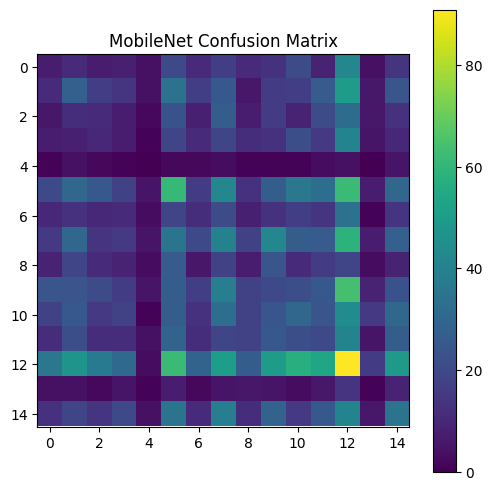

129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step


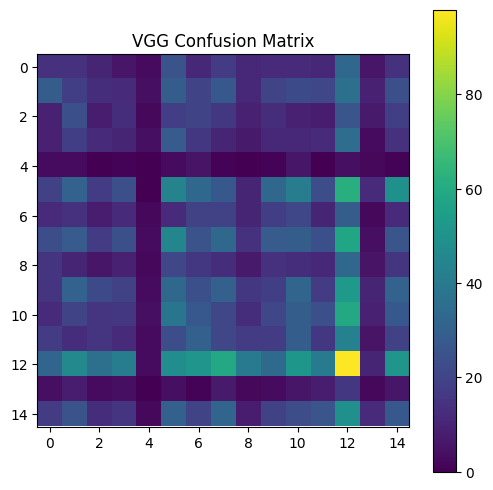

In [ ]:
def plot_cm(model,title):
    val_data.reset()
    preds = np.argmax(model.predict(val_data),axis=1)
    cm = confusion_matrix(val_data.classes,preds)

    plt.figure(figsize=(6,6))
    plt.imshow(cm)
    plt.title(title)
    plt.colorbar()
    plt.show()

plot_cm(model_mobile,"MobileNet Confusion Matrix")
plot_cm(model_vgg,"VGG Confusion Matrix")

In [ ]:
print("MobileNet Parameters:",model_mobile.count_params())
print("VGG Parameters:",model_vgg.count_params())

MobileNet Parameters: 3495119
VGG Parameters: 18917199


In [ ]:
final_ps3 = pd.DataFrame({
    "Model":["MobileNet","VGG"],
    "Accuracy":[mobile_results[0],vgg_results[0]],
    "Macro F1":[mobile_results[1],vgg_results[1]],
    "Balanced Acc":[mobile_results[2],vgg_results[2]],
    "GMean":[mobile_results[3],vgg_results[3]],
    "ROC AUC":[mobile_results[4],vgg_results[4]],
    "PR AUC":[mobile_results[5],vgg_results[5]],
    "Inference Time":[mobile_results[6],vgg_results[6]]
})

final_ps3

,Model,Accuracy,Macro F1,Balanced Acc,GMean,ROC AUC,PR AUC,Inference Time
0,MobileNet,0.082727,0.066602,0.066692,0.0,0.496584,0.067358,32.701582
1,VGG,0.088064,0.070597,0.071030,0.0,0.491238,0.067908,27.137670


In [ ]:
best = final_ps3.loc[final_ps3["Macro F1"].idxmax()]
best

,1
Model,VGG
Accuracy,0.088064
Macro F1,0.070597
Balanced Acc,0.07103
GMean,0.0
ROC AUC,0.491238
PR AUC,0.067908
Inference Time,27.13767


PROBLEM STATEMENT 4


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
vgg_base = VGG16(
    input_shape=(128,128,3),
    weights="imagenet",
    include_top=False
)

vgg_base.trainable = False

In [ ]:
def build_vgg_model():
    model = tf.keras.Sequential([
        vgg_base,
        layers.Flatten(),
        layers.Dense(512,activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(train_data.num_classes,activation='softmax')
    ])
    return model


PART A — LOSS FUNCTIONS

1️⃣ Baseline Cross Entropy

In [ ]:
model_ce = build_vgg_model()

model_ce.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

hist_ce = model_ce.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    class_weight=class_weights
)


Epoch 1/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 110s 207ms/step - accuracy: 0.4300 - loss: 1.8755 - val_accuracy: 0.7530 - val_loss: 0.7620
Epoch 2/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 127s 245ms/step - accuracy: 0.6580 - loss: 1.0108 - val_accuracy: 0.7686 - val_loss: 0.7233
Epoch 3/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 103s 200ms/step - accuracy: 0.6820 - loss: 0.9244 - val_accuracy: 0.7972 - val_loss: 0.6034
Epoch 4/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 103s 198ms/step - accuracy: 0.6999 - loss: 0.8593 - val_accuracy: 0.8074 - val_loss: 0.5762
Epoch 5/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 104s 202ms/step - accuracy: 0.7145 - loss: 0.8121 - val_accuracy: 0.8183 - val_loss: 0.5417


Focal Loss

In [ ]:
import tensorflow.keras.backend as K

def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true,y_pred):
        y_pred = K.clip(y_pred,1e-9,1-1e-9)
        ce = -y_true*K.log(y_pred)
        weight = alpha*K.pow(1-y_pred,gamma)
        return K.mean(weight*ce)
    return loss

In [ ]:
model_f2 = build_vgg_model()

model_f2.compile(
    optimizer='adam',
    loss=focal_loss(gamma=2),
    metrics=['accuracy']
)

hist_f2 = model_f2.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)

Epoch 1/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 111s 209ms/step - accuracy: 0.5056 - loss: 0.0203 - val_accuracy: 0.7462 - val_loss: 0.0075
Epoch 2/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 106s 206ms/step - accuracy: 0.6913 - loss: 0.0094 - val_accuracy: 0.8045 - val_loss: 0.0055
Epoch 3/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 105s 202ms/step - accuracy: 0.7124 - loss: 0.0083 - val_accuracy: 0.8016 - val_loss: 0.0050
Epoch 4/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 105s 204ms/step - accuracy: 0.7325 - loss: 0.0076 - val_accuracy: 0.8219 - val_loss: 0.0046
Epoch 5/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 105s 204ms/step - accuracy: 0.7404 - loss: 0.0071 - val_accuracy: 0.8372 - val_loss: 0.0045


Class Balanced Loss

In [ ]:
def class_balanced_loss(beta=0.9999):
    samples = np.bincount(train_data.classes)
    eff = 1-np.power(beta,samples)
    weights = (1-beta)/eff
    weights = weights/np.sum(weights)*len(samples)

    def loss(y_true,y_pred):
        y_pred = K.clip(y_pred,1e-9,1-1e-9)
        ce = -y_true*K.log(y_pred)
        return K.mean(ce*weights)

    return loss


In [ ]:
model_cb = build_vgg_model()

model_cb.compile(
    optimizer='adam',
    loss=class_balanced_loss(),
    metrics=['accuracy']
)

hist_cb = model_cb.fit(train_data,validation_data=val_data,epochs=5)

Epoch 1/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 112s 210ms/step - accuracy: 0.4517 - loss: 0.0723 - val_accuracy: 0.7356 - val_loss: 0.0329
Epoch 2/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 104s 201ms/step - accuracy: 0.6618 - loss: 0.0397 - val_accuracy: 0.7989 - val_loss: 0.0247
Epoch 3/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 102s 197ms/step - accuracy: 0.7009 - loss: 0.0354 - val_accuracy: 0.7863 - val_loss: 0.0244
Epoch 4/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 100s 193ms/step - accuracy: 0.7122 - loss: 0.0329 - val_accuracy: 0.8178 - val_loss: 0.0226
Epoch 5/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 101s 195ms/step - accuracy: 0.7240 - loss: 0.0319 - val_accuracy: 0.7785 - val_loss: 0.0238


In [ ]:
model_ls = build_vgg_model()

loss_ls = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

model_ls.compile(
    optimizer='adam',
    loss=loss_ls,
    metrics=['accuracy']
)

hist_ls = model_ls.fit(train_data,validation_data=val_data,epochs=5)

Epoch 1/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 126s 239ms/step - accuracy: 0.4893 - loss: 1.9570 - val_accuracy: 0.7848 - val_loss: 1.1920
Epoch 2/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 102s 198ms/step - accuracy: 0.6965 - loss: 1.3666 - val_accuracy: 0.8268 - val_loss: 1.0820
Epoch 3/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 101s 195ms/step - accuracy: 0.7271 - loss: 1.2922 - val_accuracy: 0.8202 - val_loss: 1.0683
Epoch 4/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 102s 198ms/step - accuracy: 0.7410 - loss: 1.2579 - val_accuracy: 0.8261 - val_loss: 1.0537
Epoch 5/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 101s 196ms/step - accuracy: 0.7555 - loss: 1.2417 - val_accuracy: 0.8498 - val_loss: 1.0316


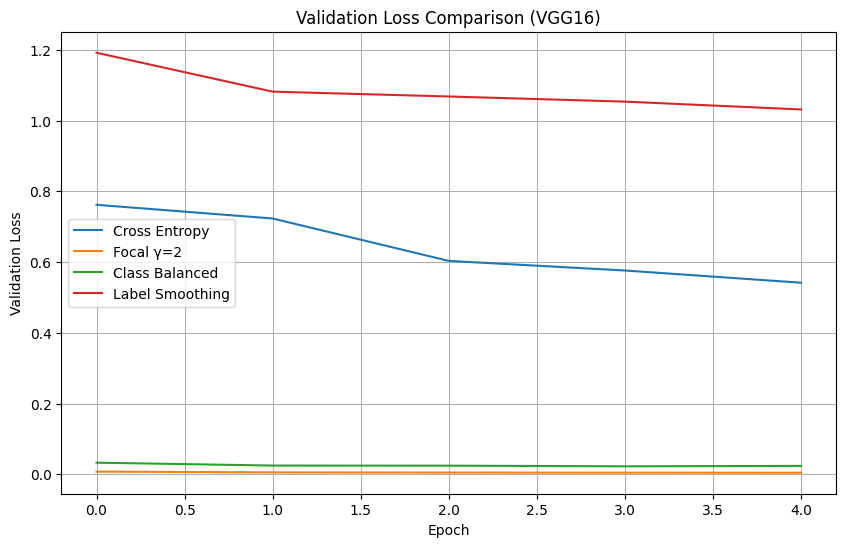

In [ ]:
 plt.figure(figsize=(10,6))

plt.plot(hist_ce.history['val_loss'], label='Cross Entropy')
plt.plot(hist_f2.history['val_loss'], label='Focal γ=2')

plt.plot(hist_cb.history['val_loss'], label='Class Balanced')
plt.plot(hist_ls.history['val_loss'], label='Label Smoothing')

plt.title("Validation Loss Comparison (VGG16)")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

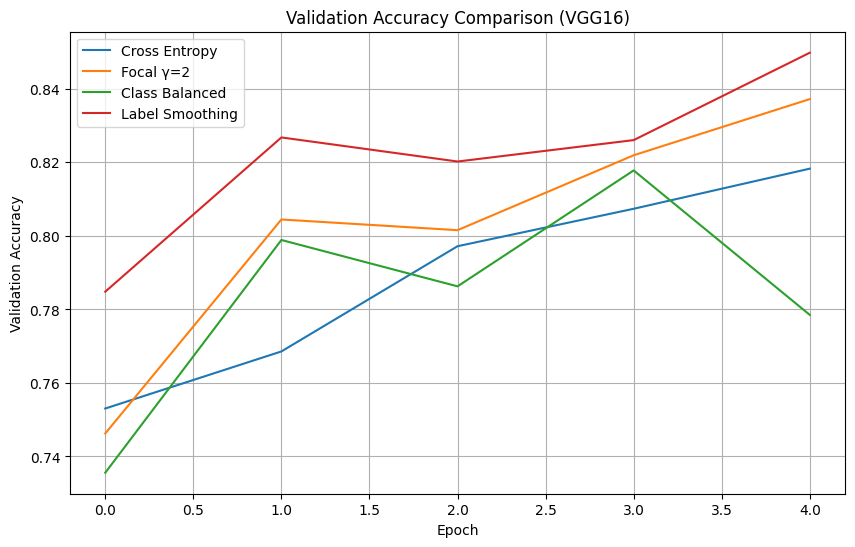

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(hist_ce.history['val_accuracy'], label='Cross Entropy')
plt.plot(hist_f2.history['val_accuracy'], label='Focal γ=2')
plt.plot(hist_cb.history['val_accuracy'], label='Class Balanced')
plt.plot(hist_ls.history['val_accuracy'], label='Label Smoothing')

plt.title("Validation Accuracy Comparison (VGG16)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


PS 5

In [ ]:
img_size = 128
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_data = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


In [ ]:
labels = train_data.classes

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(weights))

In [ ]:
from tensorflow.keras.applications import VGG16

vgg_base = VGG16(
    input_shape=(128,128,3),
    weights="imagenet",
    include_top=False
)

vgg_base.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def build_vgg_model():
    model = tf.keras.Sequential([
        vgg_base,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(train_data.num_classes, activation='softmax')
    ])
    return model

In [ ]:
model = build_vgg_model()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,917,199 (72.16 MB)

 Trainable params: 4,202,511 (16.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=4,
    class_weight=class_weights
)

Epoch 1/4


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


517/517 ━━━━━━━━━━━━━━━━━━━━ 60s 98ms/step - accuracy: 0.4701 - loss: 1.7312 - val_accuracy: 0.7965 - val_loss: 0.6461
Epoch 2/4
517/517 ━━━━━━━━━━━━━━━━━━━━ 55s 107ms/step - accuracy: 0.7155 - loss: 0.8284 - val_accuracy: 0.8273 - val_loss: 0.5236
Epoch 3/4
517/517 ━━━━━━━━━━━━━━━━━━━━ 49s 94ms/step - accuracy: 0.7715 - loss: 0.6666 - val_accuracy: 0.8370 - val_loss: 0.4882
Epoch 4/4
517/517 ━━━━━━━━━━━━━━━━━━━━ 44s 85ms/step - accuracy: 0.7943 - loss: 0.5825 - val_accuracy: 0.8712 - val_loss: 0.4001


In [ ]:
_ = model.predict(val_data, steps=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [ ]:
feature_extractor = tf.keras.Model(
    inputs=model.inputs,
    outputs=model.layers[-2].output
)

In [ ]:
val_data.reset()

features = feature_extractor.predict(val_data)
labels = val_data.classes

print("Feature shape:", features.shape)

129/129 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step
Feature shape: (4122, 512)


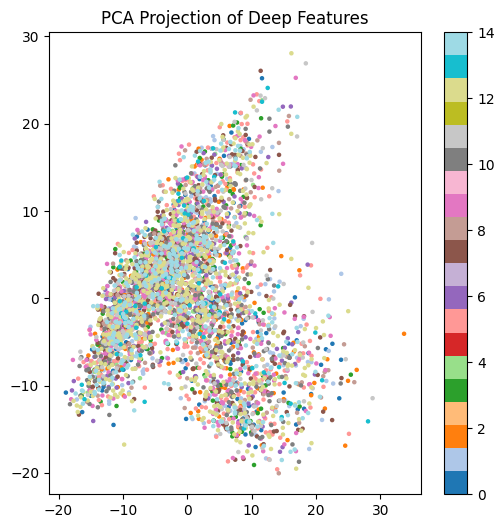

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_feat = pca.fit_transform(features)

plt.figure(figsize=(6,6))
plt.scatter(pca_feat[:,0], pca_feat[:,1], c=labels, cmap='tab20', s=5)
plt.title("PCA Projection of Deep Features")
plt.colorbar()
plt.show()

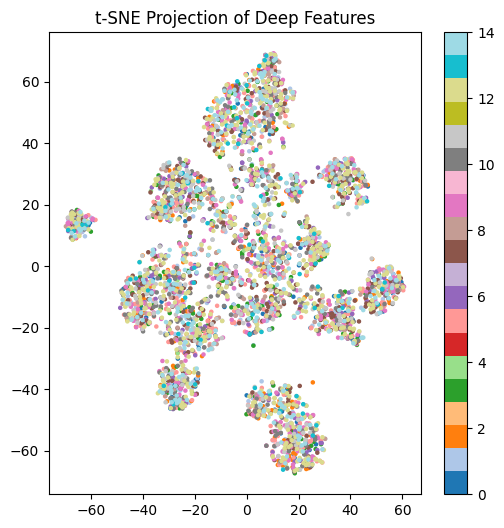

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_feat = tsne.fit_transform(features)

plt.figure(figsize=(6,6))
plt.scatter(tsne_feat[:,0], tsne_feat[:,1], c=labels, cmap='tab20', s=5)
plt.title("t-SNE Projection of Deep Features")
plt.colorbar()
plt.show()

In [ ]:
!pip install umap-learn

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


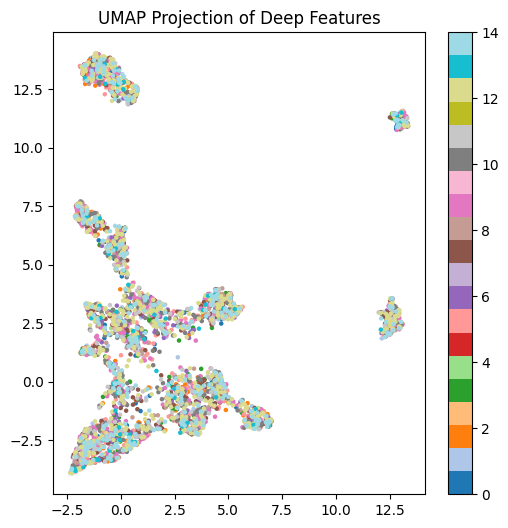

In [ ]:
import umap

reducer = umap.UMAP(n_components=2, random_state=42)
umap_feat = reducer.fit_transform(features)

plt.figure(figsize=(6,6))
plt.scatter(umap_feat[:,0], umap_feat[:,1], c=labels, cmap='tab20', s=5)
plt.title("UMAP Projection of Deep Features")
plt.colorbar()
plt.show()

In [ ]:
import cv2

def make_gradcam(img_array, model, last_conv_layer_name):

    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))

    heatmap = conv_outputs[0] @ pooled[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap,0)/tf.math.reduce_max(heatmap)

    return heatmap.numpy()

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

val_data.reset()

probs = model.predict(val_data)
y_pred = np.argmax(probs, axis=1)
y_true = val_data.classes
class_names = list(val_data.class_indices.keys())

129/129 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step


In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names))

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.04      0.05      0.04       199
                     Pepper__bell___healthy       0.06      0.06      0.06       295
                      Potato___Early_blight       0.06      0.06      0.06       200
                       Potato___Late_blight       0.05      0.06      0.05       200
                           Potato___healthy       0.00      0.00      0.00        30
                      Tomato_Bacterial_spot       0.13      0.12      0.13       425
                        Tomato_Early_blight       0.06      0.06      0.06       200
                         Tomato_Late_blight       0.10      0.10      0.10       381
                           Tomato_Leaf_Mold       0.03      0.04      0.03       190
                  Tomato_Septoria_leaf_spot       0.09      0.08      0.09       354
Tomato_Spider_mites_Two_spotted_spider_mite       0.09      0.09

In [ ]:
errors_per_class = {}

for i in range(len(class_names)):
    errors = np.sum((y_true == i) & (y_pred != i))
    errors_per_class[class_names[i]] = errors

sorted(errors_per_class.items(), key=lambda x: x[1], reverse=True)

[('Tomato__Tomato_YellowLeaf__Curl_Virus', np.int64(566)),
 ('Tomato_Bacterial_spot', np.int64(372)),
 ('Tomato_Late_blight', np.int64(342)),
 ('Tomato_Septoria_leaf_spot', np.int64(325)),
 ('Tomato_Spider_mites_Two_spotted_spider_mite', np.int64(304)),
 ('Tomato_healthy', np.int64(294)),
 ('Pepper__bell___healthy', np.int64(278)),
 ('Tomato__Target_Spot', np.int64(261)),
 ('Pepper__bell___Bacterial_spot', np.int64(190)),
 ('Potato___Late_blight', np.int64(189)),
 ('Tomato_Early_blight', np.int64(189)),
 ('Potato___Early_blight', np.int64(188)),
 ('Tomato_Leaf_Mold', np.int64(183)),
 ('Tomato__Tomato_mosaic_virus', np.int64(72)),
 ('Potato___healthy', np.int64(30))]

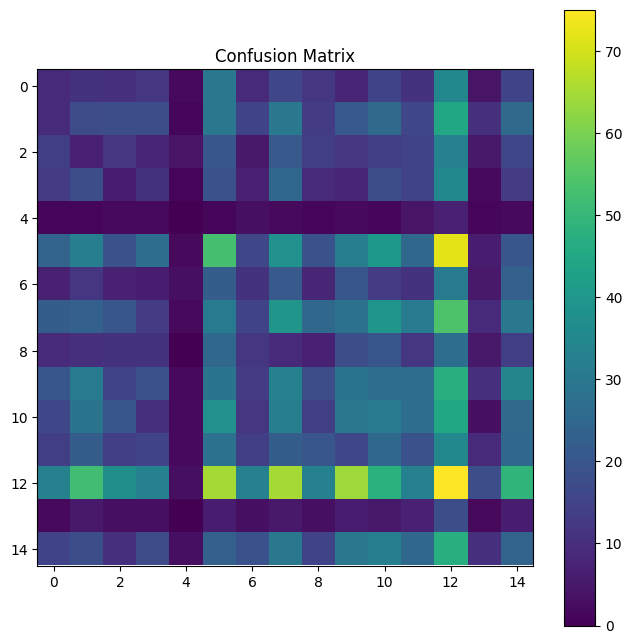

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,8))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.colorbar()
plt.show()

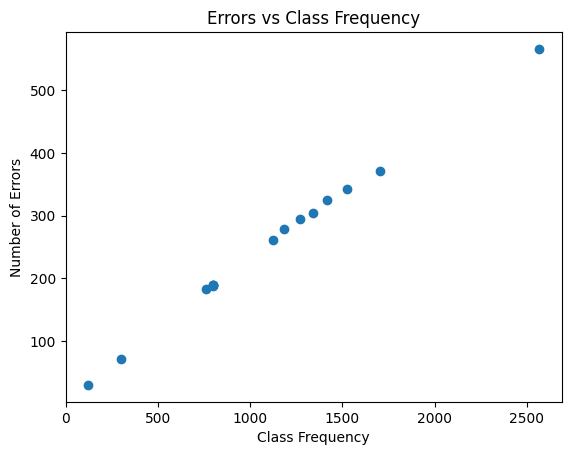

In [ ]:
class_counts = np.bincount(train_data.classes)

error_list = [errors_per_class[c] for c in class_names]

plt.scatter(class_counts, error_list)
plt.xlabel("Class Frequency")
plt.ylabel("Number of Errors")
plt.title("Errors vs Class Frequency")
plt.show()

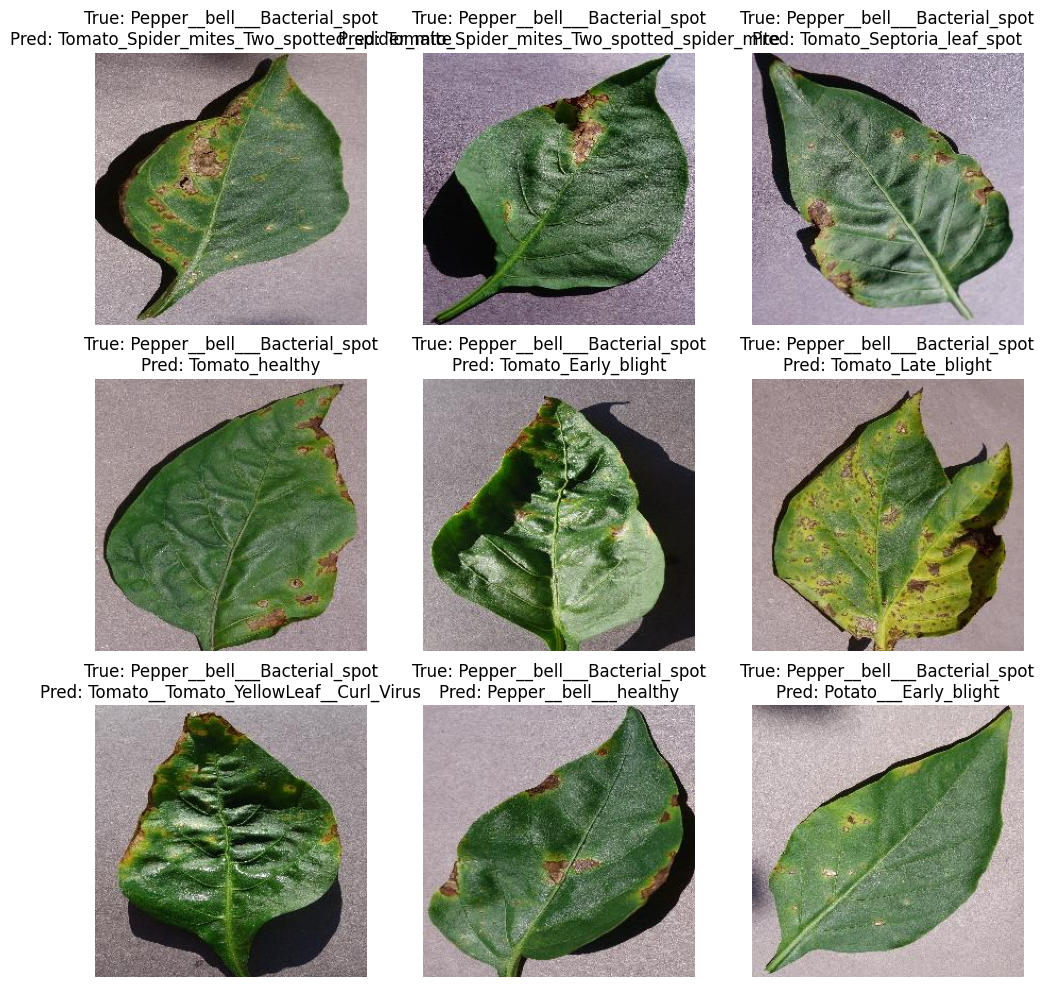

In [ ]:
misclassified = np.where(y_pred != y_true)[0]

plt.figure(figsize=(12,12))

for i in range(9):
    idx = misclassified[i]
    img_path = val_data.filepaths[idx]

    img = plt.imread(img_path)

    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}")
    plt.axis('off')

plt.show()